In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import math
import torch.distributions as dists
from scem import loss, util, kernel, net, stein, cpdkernel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import dirname, join
import ksdmom.sampler as samp
from collections import namedtuple

In [4]:
torch.manual_seed(101)

In [5]:
results_path = '/nfs/gatsbystor/heishiro/ksd-unbounded/results/mixture'
problem = 'Gaussian_mode_vs_sample_size'

In [6]:
dir_path = (join(results_path, problem))
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [7]:
font = {
    'family' : 'serif',
#     'weight' : 'bold',
    'size'   : 24
}
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', **font)
plt.rc('lines', linewidth=3, markersize=10)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [8]:
class Normal:
    def __init__(self, m, s):
        self.m = m 
        self.s = s
    
    def den(self, X):
        m = self.m
        s = self.s 
        
        den = torch.exp(-torch.sum((X-m)**2, axis=1)/(2*s**2))
        den /= (2*math.pi*s**2)**(d/2)
        return den
    
    def log_den(self, X):
        m = self.m
        s = self.s
        ld = -torch.sum((X-m)**2, axis=1)/(2*s**2)
        ld -= d/2 * torch.log(torch.tensor(2*math.pi*s**2))
        return ld
    
    def score(self, X):
        m = self.m 
        s = self.s
        return -(X-m) / s**2
    
    def sample(self, n):
        m = self.m
        d = len(m)
        return m + self.s * torch.randn(n, d)
    
class MixNormal:
    def __init__(self, m1, m2, s1, s2, mweights):
        self.m1 = m1
        self.m2 = m2
        self.s1 = s1
        self.s2 = s2
        self.n1 = Normal(m1, s1)
        self.n2 = Normal(m2, s2)
        self.mweights = mweights
    
    def score(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        mweights = self.mweights

        logden1 = self.n1.log_den(X)
        logden2 = self.n2.log_den(X)

        score1 = -(X - m1)/(s1**2) 
        score2 = -(X - m2)/(s2**2) 
        
        post_prob1 = 1. / (1. + (mweights[1]/mweights[0])*torch.exp(logden2-logden1))
        post_prob1 = post_prob1.unsqueeze(1)
        post_prob2 = 1. - post_prob1
        sc = post_prob1*score1 + post_prob2*score2
        return sc
    
    def den(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        w = self.mweights
        den1 = torch.exp(-torch.sum((X-m1)**2, axis=1)/(2*s1**2))
        den1 /= (2*math.pi*s1**2)**(d/2)
        den2 = torch.exp(-torch.sum((X-m2)**2, axis=1)/(2*s2**2))
        den2 /= (2*math.pi*s2**2)**(d/2)
        return w[0]*den1 + w[1]*den2
    
    def log_den(self, X):
        return torch.log(self.den(X))
    
    def sample(self, n):
        m = torch.distributions.Binomial(n, torch.tensor([self.mweights[0]]))        
        n1 = int(m.sample().item())
        n2 = n - n1 
        d = len(self.m1)
        X1 = self.s1*torch.randn(n1, d) + self.m1
        X2 = self.s2*torch.randn(n2, d) + self.m2
        X = torch.cat([X1, X2])
        for _ in range(1):
            idx = torch.randperm(n)
            X = X[idx]
        return X

In [13]:
d = 5
m = torch.zeros(d)
s = 1.

In [14]:
kimq  = kernel.KIMQ(b=-0.5)
loc = None
klin = kernel.KLinear(scale=1, loc=loc, bias=1)
w = kernel.MultiquadraticWeight(p=-0.5, bias=1, loc=loc)
kw = kernel.KSTWeight(w_func=w)
ktilted_lin = kernel.KSTProduct(klin, kw)
kimq_sum = kernel.KSTSumKernel([ktilted_lin, kimq])

kmat = kernel.KMatern(scale=1)
kmat_sum = kernel.KSTSumKernel([ktilted_lin, kmat])

kernels = {
#     'IMQ': kimq,
    'IMQ-sum': kimq_sum, 
#     'Mat-sum': kmat_sum,
}

In [15]:
ns = 30
sample_sizes = torch.logspace(1, 4, ns, dtype=torch.int64)
sample_sizes = torch.cat([sample_sizes, torch.tensor([11000, 12000, 13000, 14000, 15000])])
ps = torch.tensor([3., 5.,])
n_ps = len(ps)

In [16]:
data = np.empty([n_ps, len(sample_sizes), 2])
norm_ones = (torch.ones(d) / d**0.5)
targets = [MixNormal(m+p*norm_ones, m, s, s, 0.5*(torch.ones(2))) for p in ps]
models = [MixNormal(m+p*norm_ones, m, s, s, torch.tensor([0.1, 0.9])) for p in ps]

k = kimq
losses = {
    target: loss.KSD(k, target.score) 
    for target in targets
}
weight = None
ratio = 0.1
for l_i, (key, l) in enumerate(losses.items()):
    model = models[l_i]
    for i, n in enumerate(sample_sizes):
        print(n)
        X = model.sample(int(n))
        data[l_i, i, 0] = l.loss(X, vstat=True, weight=weight, ignore_diag=False).detach().numpy()
        X = key.sample(int(n))
        data[l_i, i, 1] = l.loss(X, vstat=True, weight=weight, ignore_diag=False).detach().numpy()

tensor(10)
tensor(12)
tensor(16)
tensor(20)
tensor(25)
tensor(32)
tensor(41)
tensor(52)
tensor(67)
tensor(85)
tensor(108)
tensor(137)
tensor(174)
tensor(221)
tensor(280)
tensor(356)
tensor(452)
tensor(573)
tensor(727)
tensor(923)
tensor(1172)
tensor(1487)
tensor(1887)
tensor(2395)
tensor(3039)
tensor(3856)
tensor(4893)
tensor(6210)
tensor(7880)
tensor(10000)
tensor(11000)
tensor(12000)
tensor(13000)
tensor(14000)
tensor(15000)
tensor(10)
tensor(12)
tensor(16)
tensor(20)
tensor(25)
tensor(32)
tensor(41)
tensor(52)
tensor(67)
tensor(85)
tensor(108)
tensor(137)
tensor(174)
tensor(221)
tensor(280)
tensor(356)
tensor(452)
tensor(573)
tensor(727)
tensor(923)
tensor(1172)
tensor(1487)
tensor(1887)
tensor(2395)
tensor(3039)
tensor(3856)
tensor(4893)
tensor(6210)
tensor(7880)
tensor(10000)
tensor(11000)
tensor(12000)
tensor(13000)
tensor(14000)
tensor(15000)


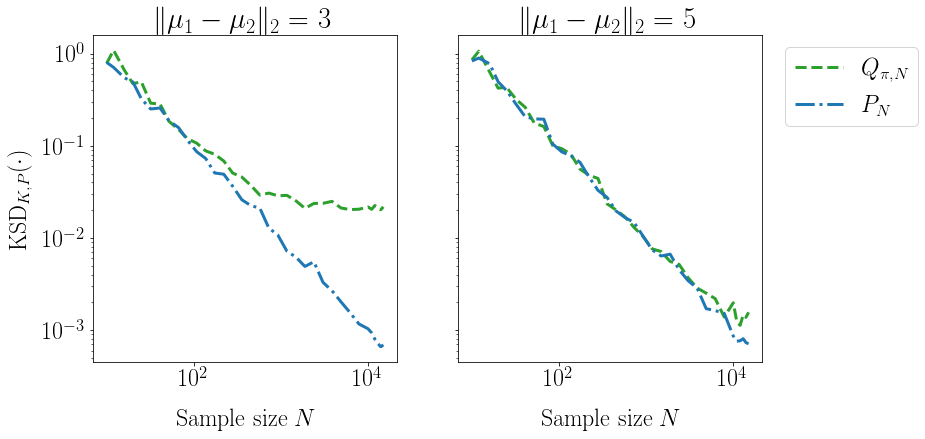

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=n_ps, sharey=True,
                         figsize=(6*n_ps, 6))

for pi, p in enumerate(ps):
    ax = axes if len(ps) == 1 else axes[pi]
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.title.set_text('$\\|\\mu_1 - \\mu_2 \\|_2$ = {}'.format(int(p)))

    label = ax.set_xlabel('Sample size $N$', fontsize = 24)
    ax.xaxis.set_label_coords(0.5, -0.15)

    if pi == 0:
        label = ax.set_ylabel('$\\mathrm{KSD}_{K,P}(\mathbf{\cdot})$', fontsize = 24)
#         label.set_rotation(0)
#         ax.yaxis.set_label_coords(-0.1, 1.05)
        ax.yaxis.set_label_coords(-0.2, 0.5)    

    ax.plot(sample_sizes, data[pi, :, 0], label='$Q_{\\pi, N}$', 
            color='C2', linestyle='--')
    ax.plot(sample_sizes, data[pi, :, 1], label='$P_N$', 
            color='C10', linestyle='-.')
ax.legend(bbox_to_anchor=(1.55,1.), ncol=1)
# plt.legend(bbox_to_anchor=(3.75,1.), ncol=4)
# ax.set_yscale('log')
#ax.yaxis.set_minor_locator(LogLocator(numticks=10))

plt.savefig('ksd_gauss_mixture_IMQlin_sample_size.pdf', bbox_inches='tight')